In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.inspection import PartialDependenceDisplay

In [21]:
df = pd.read_csv('data/clean.csv')

In [22]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [23]:
label_encoder = LabelEncoder()
X = df

encoding_dict = {}
categorical_columns = X.select_dtypes(include=['object']).columns

for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])
    encoding_dict[col] = label_encoder.classes_

In [24]:

X = df.drop(columns=["Attrition"])
y = label_encoder.fit_transform(df["Attrition"])

In [25]:
for col, encoding in encoding_dict.items():
    print(f"Codificación '{col}':")
    print(dict(zip(encoding, range(len(encoding)))))
    print()

Codificación 'Attrition':
{'No': 0, 'Yes': 1}

Codificación 'BusinessTravel':
{'Non-Travel': 0, 'Travel_Frequently': 1, 'Travel_Rarely': 2}

Codificación 'Department':
{'Human Resources': 0, 'Research & Development': 1, 'Sales': 2}

Codificación 'EducationField':
{'Human Resources': 0, 'Life Sciences': 1, 'Marketing': 2, 'Medical': 3, 'Other': 4, 'Technical Degree': 5}

Codificación 'Gender':
{'Female': 0, 'Male': 1}

Codificación 'JobRole':
{'Healthcare Representative': 0, 'Human Resources': 1, 'Laboratory Technician': 2, 'Manager': 3, 'Manufacturing Director': 4, 'Research Director': 5, 'Research Scientist': 6, 'Sales Executive': 7, 'Sales Representative': 8}

Codificación 'MaritalStatus':
{'Divorced': 0, 'Married': 1, 'Single': 2}

Codificación 'Over18':
{'Y': 0}

Codificación 'OverTime':
{'No': 0, 'Yes': 1}



In [26]:
print(label_encoder.classes_)

[0 1]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='recall', cv=3)
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='recall')

In [30]:
model = grid_search.best_estimator_

In [31]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

Precisión del modelo: 0.87


In [32]:
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       255
           1       0.50      0.36      0.42        39

    accuracy                           0.87       294
   macro avg       0.70      0.65      0.67       294
weighted avg       0.85      0.87      0.86       294



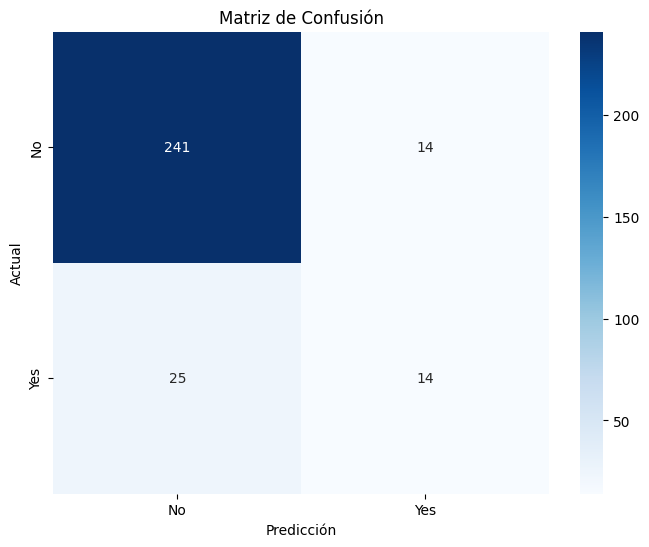

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [34]:
feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importancia': model.feature_importances_
    }).sort_values('Importancia', ascending=False)

In [38]:
feature_importances

,Feature,Importancia
26,StockOptionLevel,0.094598
17,MonthlyIncome,0.066042
15,JobSatisfaction,0.052275
33,YearsWithCurrManager,0.043060
2,DailyRate,0.040222
8,EmployeeNumber,0.040076
18,MonthlyRate,0.039623
12,JobInvolvement,0.039586
13,JobLevel,0.039195
29,WorkLifeBalance,0.038740


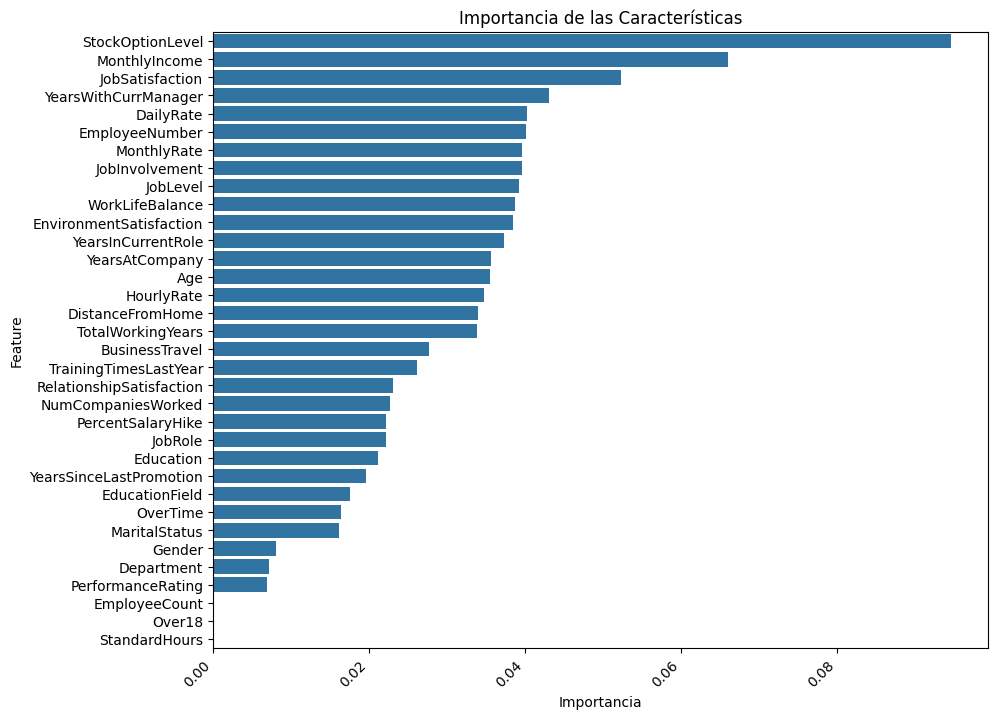

In [35]:
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['Importancia'], y=feature_importances['Feature'])
plt.title('Importancia de las Características')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


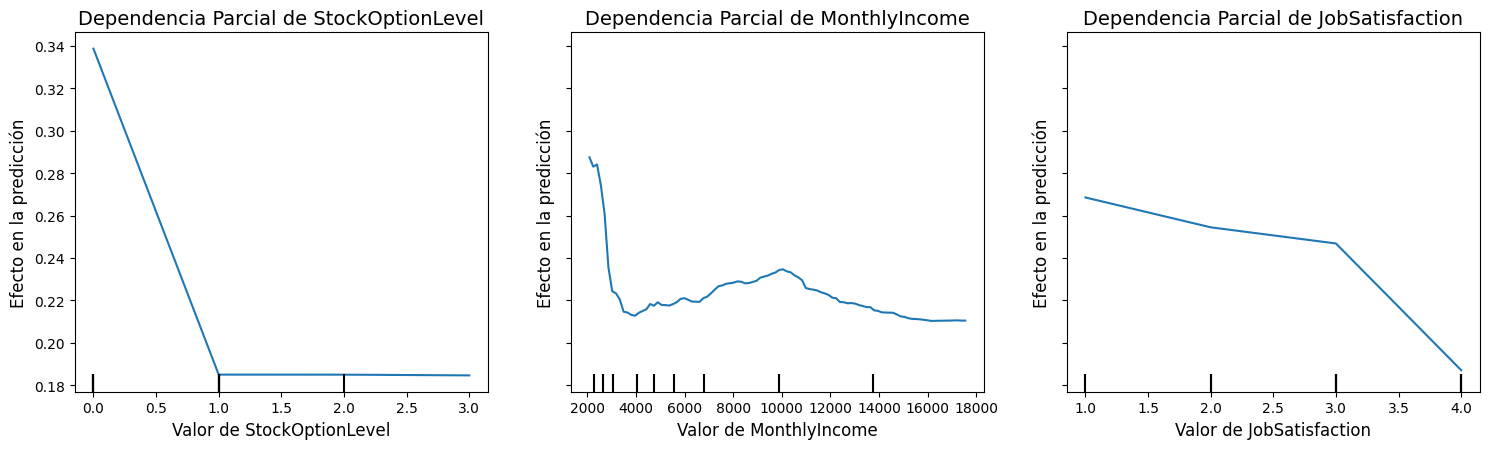

In [95]:
features = list(feature_importances['Feature'][:3]) 

display = PartialDependenceDisplay.from_estimator(
    model, 
    X_train, 
    features,
    grid_resolution=100,
    kind="average"  
)

fig = plt.gcf()
fig.set_size_inches(15, 5)

for i, ax in enumerate(display.axes_.flatten()):
    ax.set_ylabel('Efecto en la predicción', fontsize=12)
    ax.set_xlabel(f'Valor de {features[i]}', fontsize=12)
    
    ax.set_title(f'Dependencia Parcial de {features[i]}', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
